In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.set_figure_params(dpi=150)

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
path = 'data/200821_HLN_POD2300/premrna_outs/filtered_feature_bc_matrix'
adata = sc.read_10x_mtx(path,
                        var_names='gene_symbols',
                        cache=False)
adata.var_names_make_unique()
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 1378 × 33538
    var: 'gene_ids', 'feature_types'

In [4]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = np.array([gene.startswith('MT-') for gene in adata.var_names])
adata.obs['mt_frac'] = np.array(adata.X[:, mt_gene_mask].sum(1)).flatten()/adata.obs['n_counts']

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


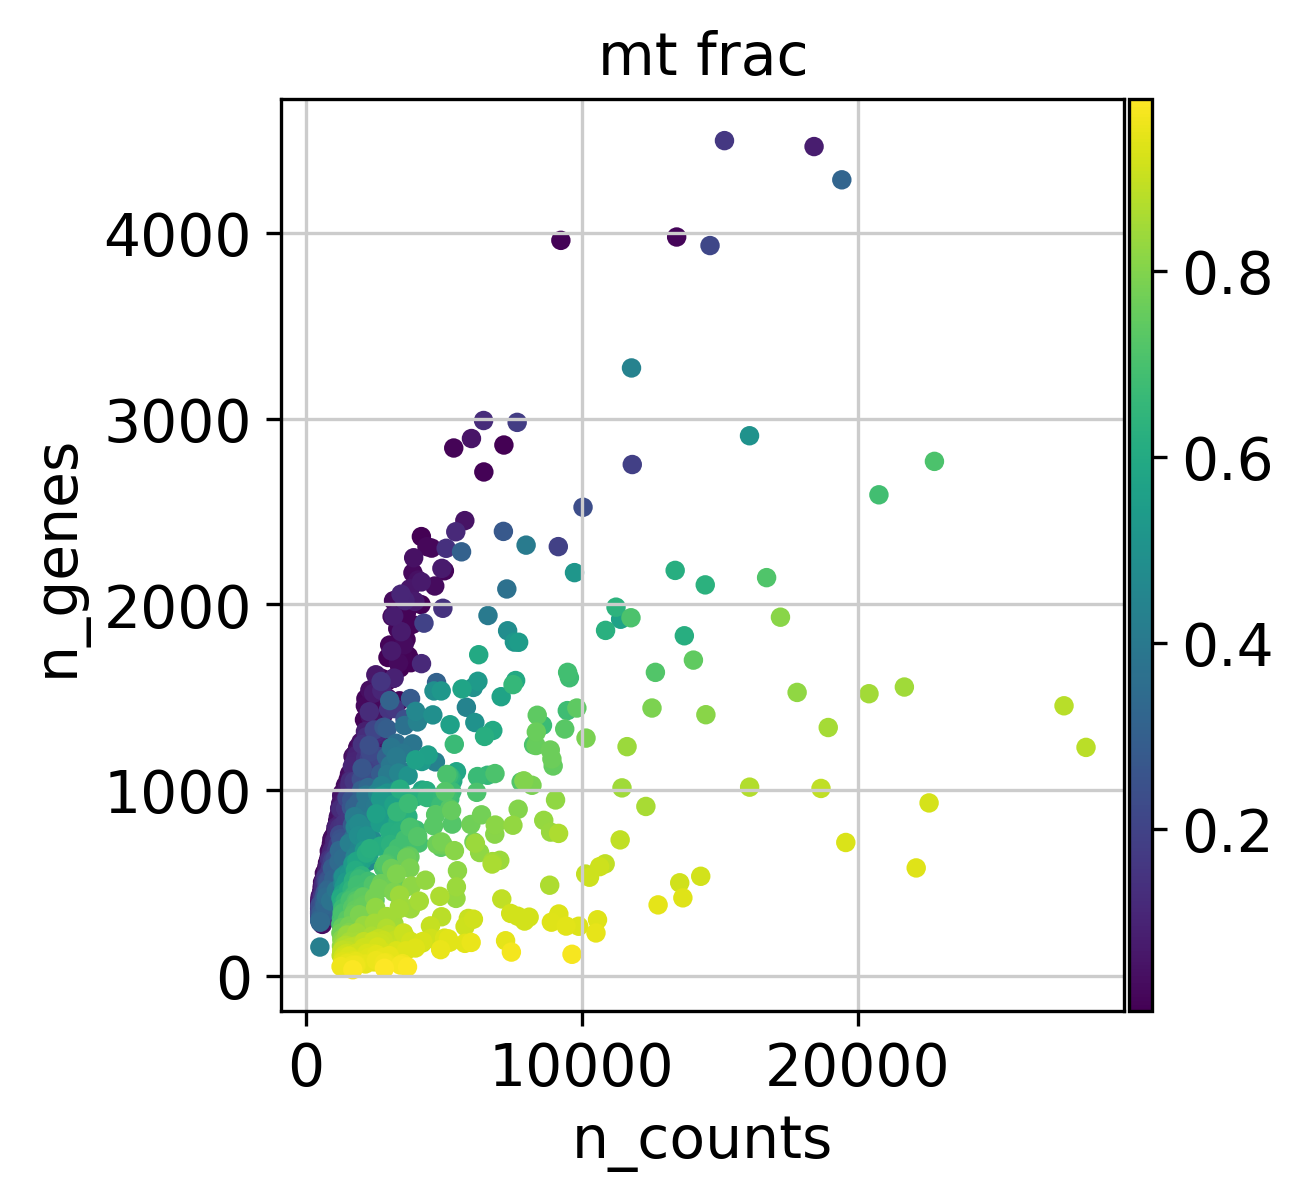

In [5]:
sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')

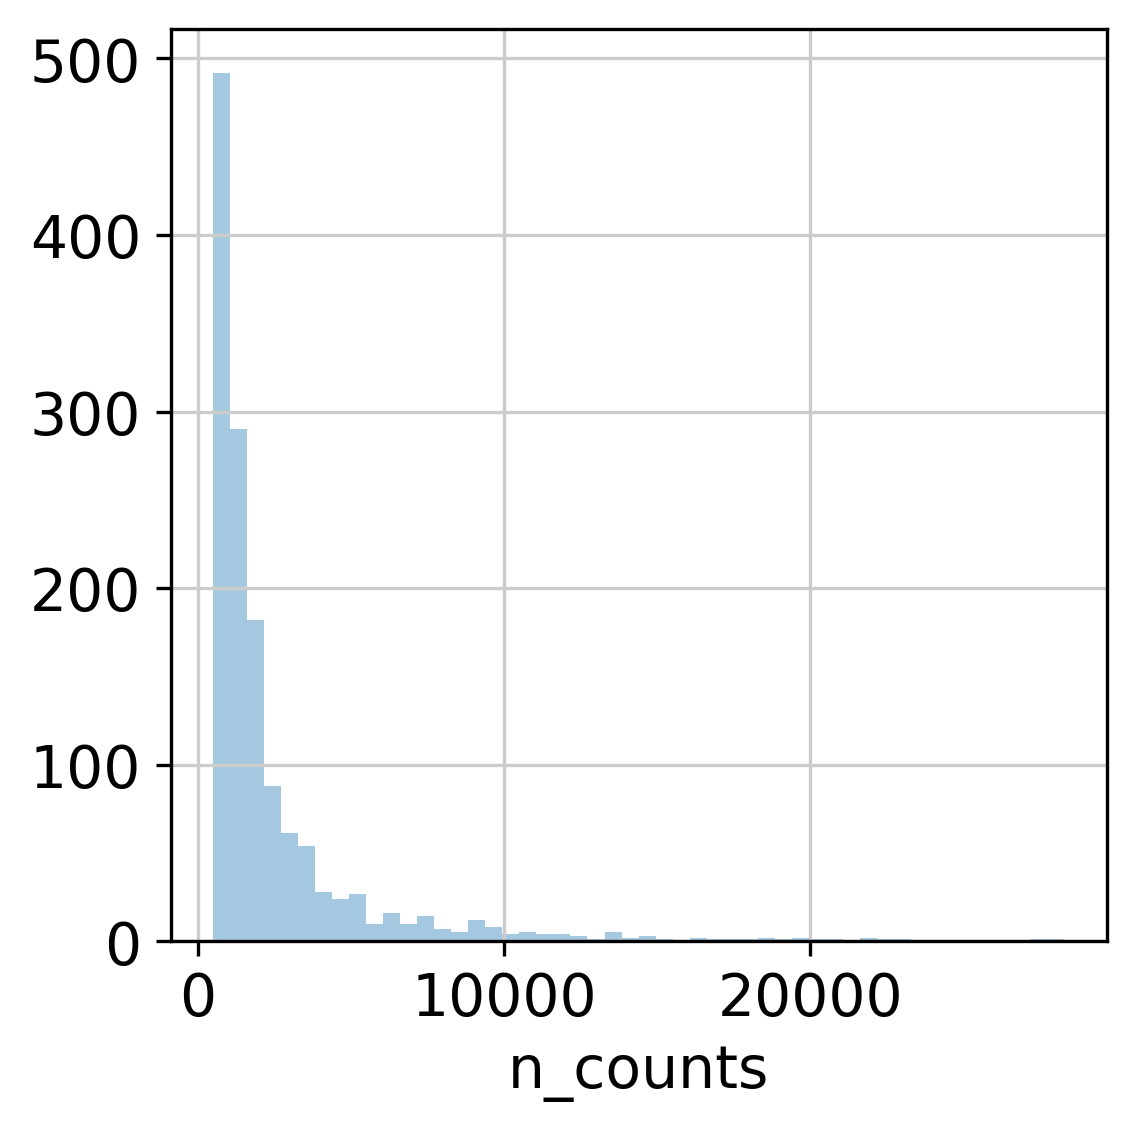

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


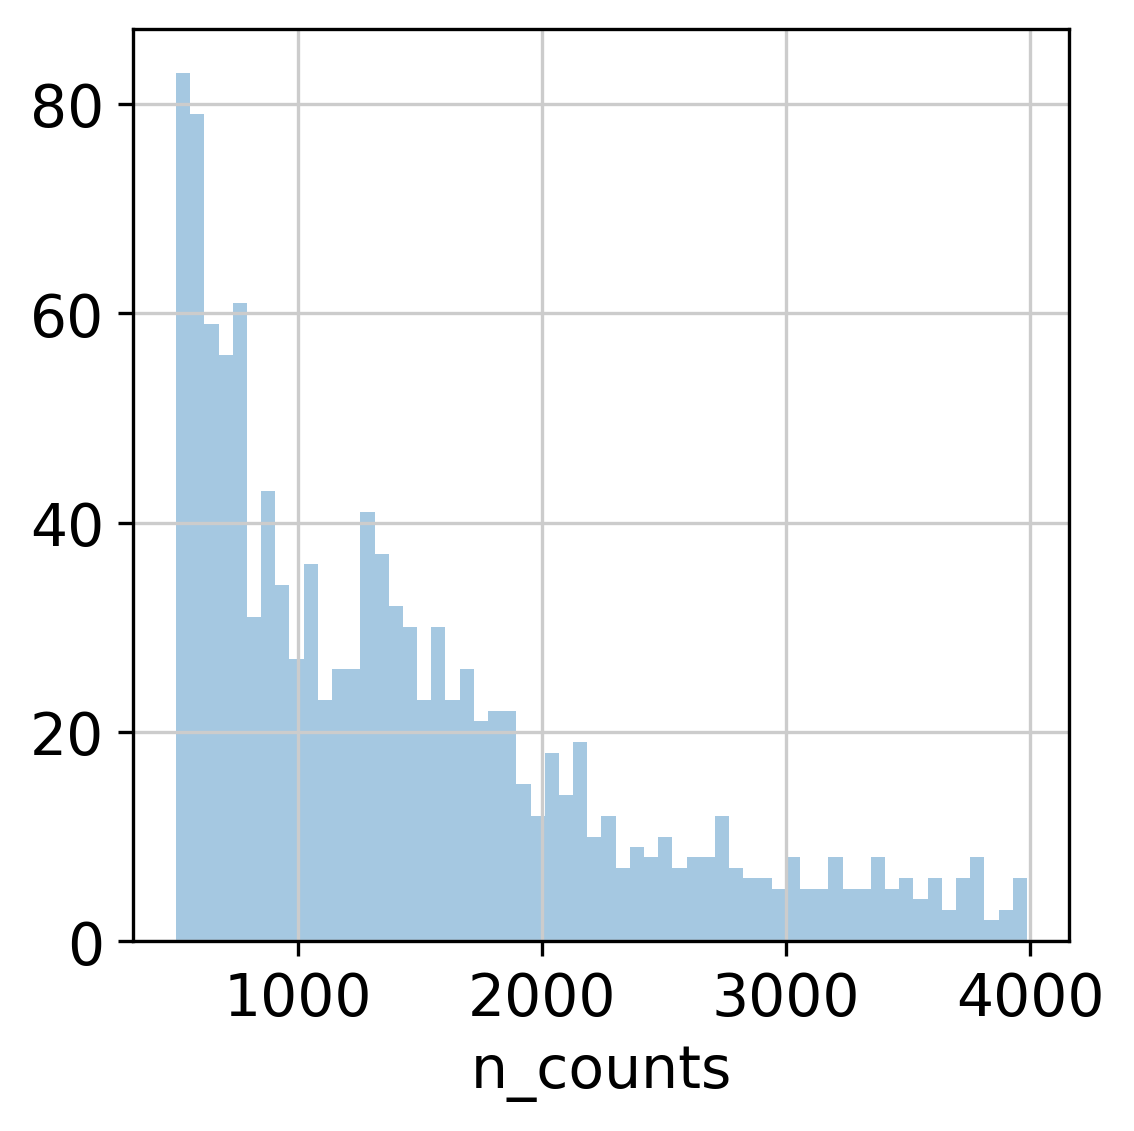

In [9]:
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

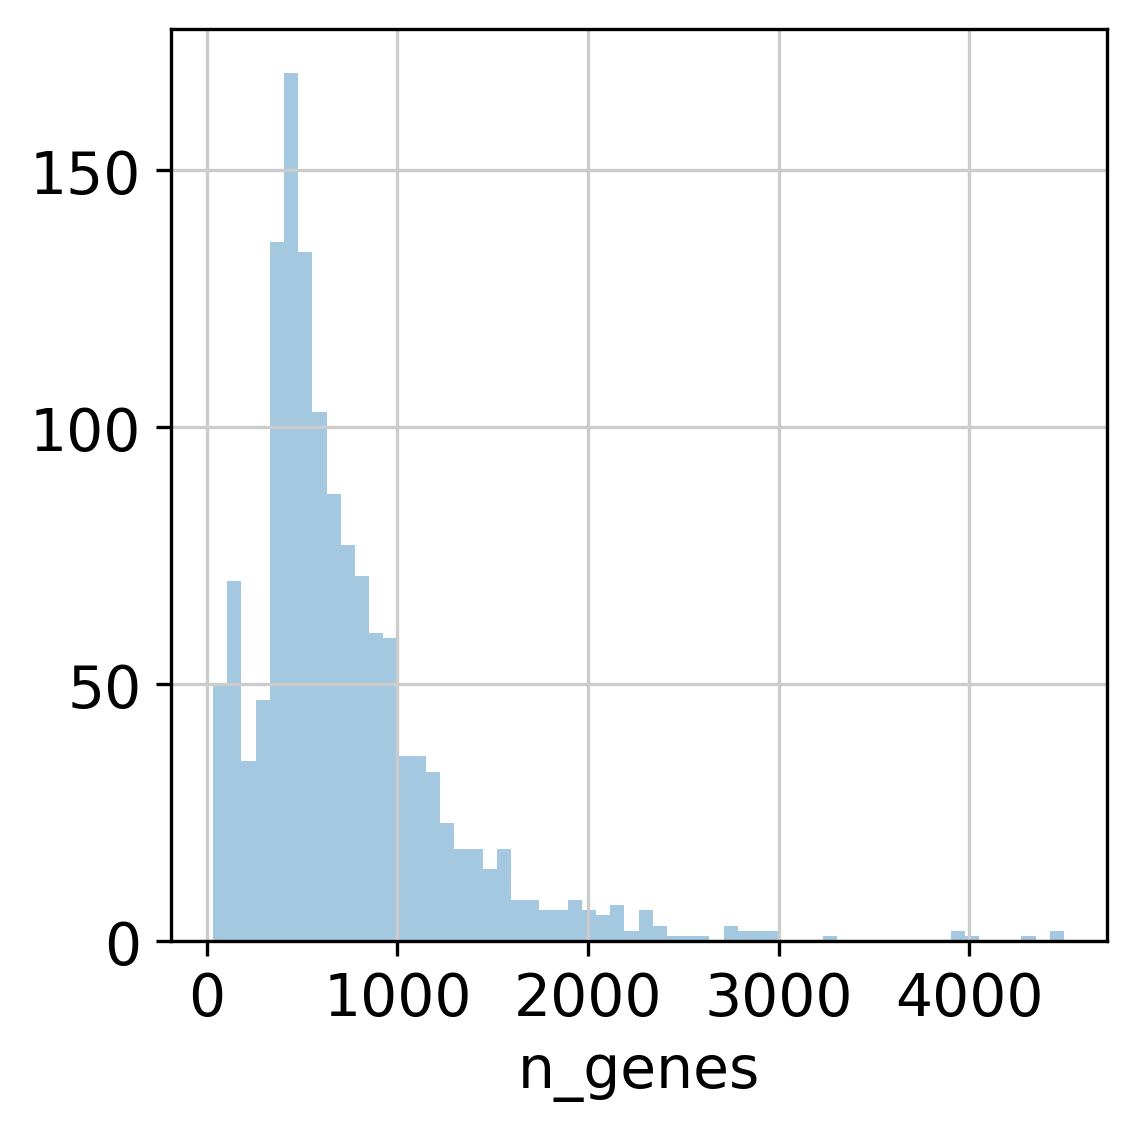

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


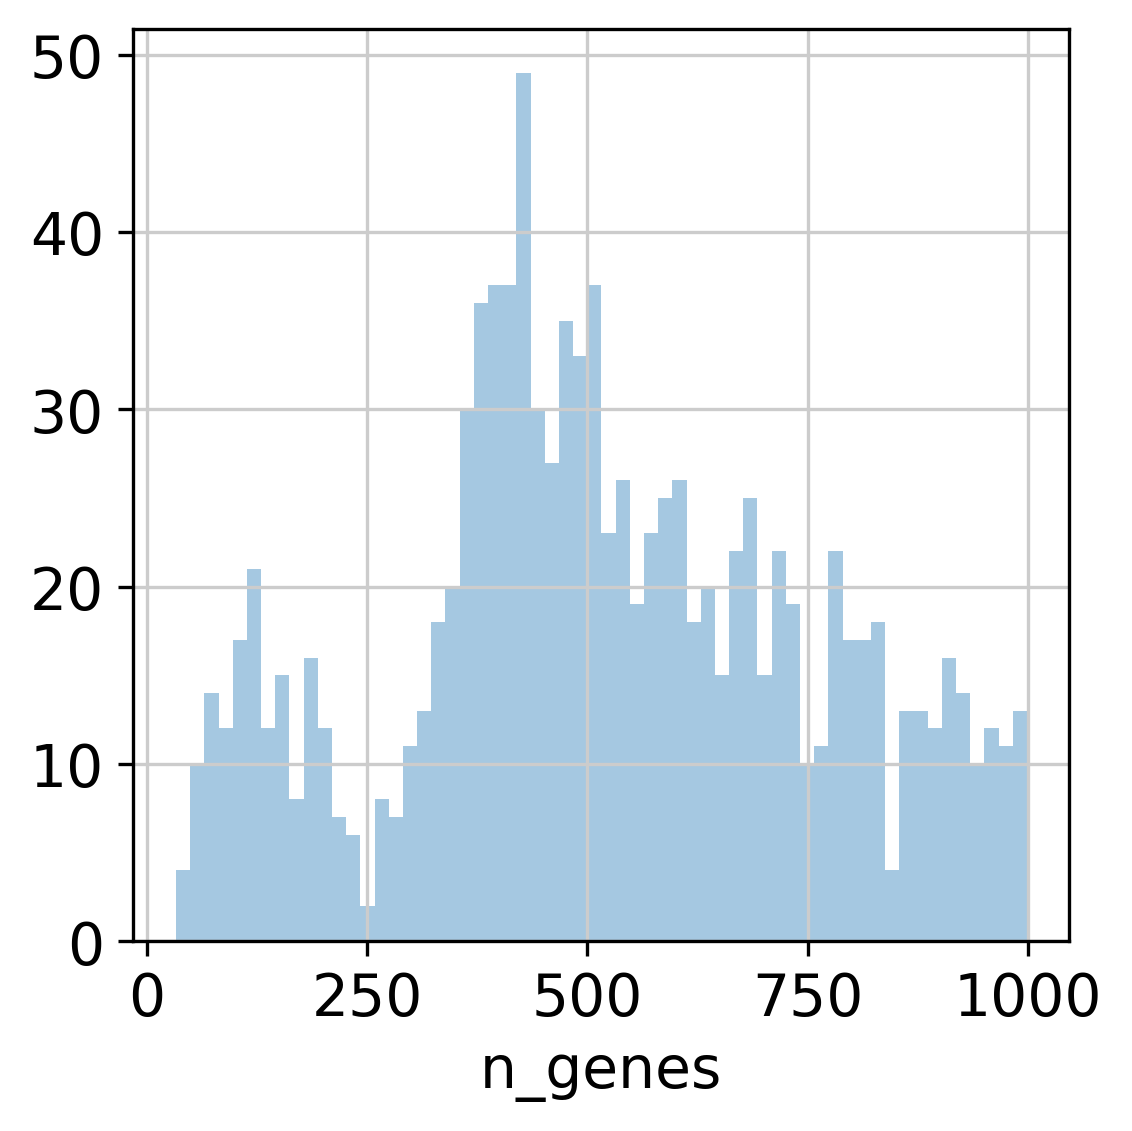

In [11]:
#Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [12]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 2500)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 250)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 1378
Number of cells after min count filter: 1378
filtered out 357 cells that have more than 2500 counts


/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


Number of cells after max count filter: 1021
Number of cells after MT filter: 623
Number of cells after gene filter: 623


In [13]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
filtered out 27724 genes that are detected in less than 20 cells
Number of genes after cell filter: 5814


In [17]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering


/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished: found 7 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [18]:
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [19]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].set_title('n_genes_by_counts')
sns.violinplot(y=adata.obs['n_genes_by_counts'], ax=ax[0])
ax[0].set_ylabel('')

ax[1].set_title('total_counts')
sns.violinplot(y=adata.obs['total_counts'], ax=ax[1])
ax[1].set_ylabel('')

ax[2].set_title('pct_counts_mt')
sns.violinplot(y=adata.obs['pct_counts_mt'], ax=ax[2])
ax[2].set_ylabel('')

plt.tight_layout()

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', )

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[512 < adata.obs.n_genes_by_counts, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [ ]:
adata

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata)

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata)

In [ ]:
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
sc.pl.umap(adata, color=['ALB', 'TF', 'TTR', 'HNF4A','CYP2A6'])

In [ ]:
sc.tl.rank_genes_groups(adata, method='wilcoxon', groupby='leiden')

In [ ]:
sc.pl.rank_genes_groups(adata, key='rank_genes_groups', fontsize=12)

In [ ]:
marker_genes = dict()
marker_genes['MP'] = ['CD68','ITGAM','ITGAX','HLA-DRA','CSF1R','CD14']
marker_genes['pDC'] = ['LILRA4', 'CLEC4C', 'GZMB']
marker_genes['ILC'] = ['KLRF1', 'KLRC1', 'GZMA', 'GZMB', 'NKG7']
marker_genes['Tcell'] = ['CD3D', 'CD3E', 'CD3G', 'CD8A']
marker_genes['Bcell'] = ['CD79A', 'CD79B', 'CD19', 'MS4A1']
marker_genes['Plasmacell'] = ['CD79A', 'IGHA2']
marker_genes['Mastcell'] = ['KIT', 'TPSAB1', 'TPSB2']
marker_genes['Endothelia'] = ['PECAM1', 'CDH5', 'ICAM2', 'KDR', 'ERG']
marker_genes['Mesenchyme'] = ['PDGFRB', 'ACTA2', 'COL1A1', 'COL1A2', 'COL3A1', 'DES', 'DCN']
marker_genes['Hepatocyte'] = ['ALB', 'TF', 'TTR', 'HNF4A','CYP2A6']
marker_genes['Cholangiocyte'] = ['EPCAM', 'KRT19', 'CD24']

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, top_n_markers = 20)
cell_annotation

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=80)
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, 
                                                 normalize='reference', adj_pval_threshold=0.05)
sns.heatmap(cell_annotation_norm, cbar=False, annot=True)
plt.show()

In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
import pandas as pd
cc_genes_file ='data/Macosko_cell_cycle_genes.txt'
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = list(cc_genes['S'].dropna())
g2m_genes = list(cc_genes['G2.M'].dropna())

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes, g2m_genes)

In [ ]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

In [ ]:
adata.obs[adata.obs.leiden == '0']

In [ ]:
np.sum(adata.obs.leiden == '0')